In [1]:
from os import environ
from pathlib import Path

input_folder = Path(environ.get(
    'CROSSCOMPUTE_INPUT_FOLDER', 'batches/python/input'))
output_folder = Path(environ.get(
    'CROSSCOMPUTE_OUTPUT_FOLDER', 'batches/python/output'))
output_folder.mkdir(parents=True, exist_ok=True)

In [2]:
import json
from os.path import join

with (input_folder / 'variables.dictionary').open('rt') as f:
    variables = json.load(f)
page_title = variables['page_title']
source_uri = variables['source_uri']
# source_uri = 'https://github.com/python-organizers/conferences'
# source_uri = 'https://github.com/python-organizers/conferences/blob/main/2022.csv'
# source_uri = 'https://raw.githubusercontent.com/python-organizers/conferences/main/2022.csv'
source_uri

'https://github.com/python-organizers/conferences'

In [3]:
import re

PATH_REPOSITORY_PATTERN = re.compile(
    r'^/(?P<user_name>[\w\d\-_]+)/(?P<repository_name>[\w\d\-_]+)', re.IGNORECASE)
PATH_FILE_PATTERN = re.compile(
    r'/blob/(?P<branch_name>[\w\d\-_]+)/(?P<file_path>.*)$', re.IGNORECASE)
FILE_EXTENSIONS = ['.csv']

In [4]:
import requests

def get_branch_name(user_name, repository_name):
    request_uri = f'https://api.github.com/repos/{user_name}/{repository_name}'
    response = requests.get(request_uri)
    if response.status_code == 200:
        response_d = response.json()
        branch_name = response_d['default_branch']
    else:
        branch_name = 'master'
    return branch_name

def get_file_paths(user_name, repository_name, branch_name):
    request_uri = f'https://api.github.com/repos/{user_name}/{repository_name}/git/trees/{branch_name}'
    response = requests.get(request_uri)
    file_paths = []
    if response.status_code == 200:
        response_d = response.json()
        file_ds = response_d['tree']
        # TODO: Consider getting paths from folders
        file_paths.extend(_['path'] for _ in file_ds)
    return file_paths

In [5]:
from os.path import splitext
from urllib.parse import urlparse as parse_uri

def get_source_uris(uri):
    parsed_uri = parse_uri(uri)
    hostname = parsed_uri.hostname
    path = parsed_uri.path
    source_uris = []
    if hostname == 'github.com':
        path_repository_match = PATH_REPOSITORY_PATTERN.match(path)
        path_file_match = PATH_FILE_PATTERN.search(path)
        if path_repository_match:
            path_repository_d = path_repository_match.groupdict()
            user_name = path_repository_d['user_name']
            repository_name = path_repository_d['repository_name']
            if path_file_match:
                branch_name = path_repository_d['branch_name']
            else:
                branch_name = get_branch_name(user_name, repository_name)
                for file_path in get_file_paths(user_name, repository_name, branch_name):
                    file_extension = splitext(file_path)[1].lower()
                    if file_extension not in FILE_EXTENSIONS:
                        continue
                    source_uris.append(
                        f'https://raw.githubusercontent.com/{user_name}/{repository_name}/{branch_name}/{file_path}')
    else:
        source_uris.append(uri)
    return sorted(source_uris)

source_uris = get_source_uris(source_uri)
source_uris

['https://raw.githubusercontent.com/python-organizers/conferences/main/2017.csv',
 'https://raw.githubusercontent.com/python-organizers/conferences/main/2018.csv',
 'https://raw.githubusercontent.com/python-organizers/conferences/main/2019.csv',
 'https://raw.githubusercontent.com/python-organizers/conferences/main/2020.csv',
 'https://raw.githubusercontent.com/python-organizers/conferences/main/2021.csv',
 'https://raw.githubusercontent.com/python-organizers/conferences/main/2022.csv',
 'https://raw.githubusercontent.com/python-organizers/conferences/main/2023.csv',
 'https://raw.githubusercontent.com/python-organizers/conferences/main/2024.csv',
 'https://raw.githubusercontent.com/python-organizers/conferences/main/2025.csv']

In [6]:
import pandas as pd

source_tables = []
for uri in source_uris:
    try:
        t = pd.read_csv(uri)
        source_tables.append(t)
    except Exception:
        pass

In [7]:
source_table = pd.concat(source_tables)
for c in [
    'Start Date',
    'End Date',
    'Talk Deadline',
]:
    source_table[c] = pd.to_datetime(source_table[c], errors='coerce')
source_table.reset_index(drop=True, inplace=True)
source_table.dropna(subset=['Start Date', 'End Date'], inplace=True)
source_table[:2]

,Subject,Start Date,End Date,Location,Country,Venue,Tutorial Deadline,Talk Deadline,Website URL,Proposal URL,Sponsorship URL
0,PyCon Belarus,2017-02-04,2017-02-04,"Minsk, Minsk, Belarus",BLR,NaN,NaN,NaT,http://by.pycon.org,NaN,http://by.pycon.org/assets/files/Call_for_Part...
1,PyCon Colombia,2017-02-10,2017-02-11,"Bogotá, Capital District, Colombia",COL,NaN,NaN,NaT,https://www.pycon.co,NaN,NaN


In [8]:
from datetime import datetime

now_datetime = datetime.now()
event_table = source_table[source_table['End Date'] >= now_datetime]
len(event_table)

49

In [9]:
from collections import defaultdict

def get_next_events(t, k, f):
    t = t[t[k] >= now_datetime]
    return get_events(t, k, f)

def get_events(t, k, f):
    d = defaultdict(list)
    for i, r in t.sort_values(by=k).iterrows():
        this_datetime = r[k]
        if this_datetime < now_datetime:
            this_datetime = now_datetime
        d[f(this_datetime)].append(r)
    return dict(d)

In [10]:
def get_timestamp(x):
    return x.strftime('%Y %B')

proposals = get_next_events(
    event_table, 'Talk Deadline', get_timestamp)
conferences = get_events(
    event_table, 'Start Date', get_timestamp)

In [11]:
def get_proposal_text(r):
    proposal_datetime = r['Talk Deadline']
    if pd.isna(proposal_datetime) or proposal_datetime < now_datetime:
        return ''
    proposal_text = ' and '
    proposal_url = r['Proposal URL']
    proposal_datestamp = proposal_datetime.strftime(datestamp_format)
    if proposal_url:
        proposal_text += (
            f'[proposals are due {proposal_datestamp}]({proposal_url})')
    else:
        proposal_text += (
            f'proposals are due {proposal_datestamp}')
    return proposal_text

In [12]:
lines = [f'# {page_title}']
datestamp_format = '%A, %B %d, %Y'

def extend_lines(subtitle, events):
    if not events:
        return
    lines.append(f'## Upcoming {subtitle}')
    for timestamp, rows in events.items():
        lines.append(f'### {timestamp}')
        for r in rows:
            subject = r['Subject']
            start_datetime = r['Start Date']
            end_datetime = r['End Date']
            website_url = r['Website URL']
            proposal_text = get_proposal_text(r)
            lines.append(
                f'- [{subject}]({website_url}) is '
                f'from {start_datetime.strftime(datestamp_format)} '
                f'to {end_datetime.strftime(datestamp_format)}' + proposal_text)

In [13]:
extend_lines('Proposals', proposals)
extend_lines('Conferences', conferences)
lines.append(f'\nSee {source_uri}.')

In [14]:
with (output_folder / 'calendar.md').open('wt') as f:
    f.write('\n'.join(lines))

In [27]:
import pandas as pd

datasets_folder = Path('datasets')
unsd_table = pd.read_csv(datasets_folder / 'unsd-20240528.csv')
unsd_table.set_index('ISO-alpha3 Code', inplace=True)
region_name_by_alpha3_code = unsd_table[['Region Name']].to_dict()['Region Name']
region_name_by_alpha3_code['TWN'] = 'Asia'
region_name_by_alpha3_code['HKG'] = 'Asia'

In [28]:
# region_names = sorted(str(x) for x in set(region_name_by_alpha3_code.values()))
# region_count = len(region_names)
# region_count

In [29]:
# sorted([str(_) for _ in region_names])

In [30]:
# from matplotlib import colormaps
# colors = plt.get_cmap('tab20')(np.arange(region_count, dtype=int))
# colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

In [43]:
color_name_by_region_name = {
    'Africa': 'green',
    'Americas': 'blue',
    'Asia': 'cyan',
    'Europe': 'magenta',
    'Oceania': 'red'}
region_names = list(color_name_by_region_name.keys())
color_names = list(color_name_by_region_name.values())

In [44]:
from matplotlib import patches
patches = [patches.Patch(color=c) for c in color_names]

In [45]:
gantt_table = event_table.copy()

In [46]:
today_timestamp = pd.Timestamp(now_datetime.date())

def make_gantt_columns(row):
    reference_date = max(row['Start Date'], today_timestamp)
    row['Offset'] = (reference_date - today_timestamp).days
    row['Length'] = (row['End Date'] - reference_date).days + 1
    try:
        row['Region'] = region_name_by_alpha3_code[row['Country']]
    except KeyError:
        row['Region'] = '?'
    return row

gantt_table = event_table.copy()
gantt_table = gantt_table.apply(make_gantt_columns, axis=1)

In [62]:
maximum_offset = gantt_table['Offset'].max()
xtick_locations = [30 * _ for _ in range(0, int(maximum_offset / 30))]
xtick_locations

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

In [107]:
from datetime import timedelta

xtick_labels = [(now_datetime + timedelta(days=_)).strftime('%Y %b') for _ in xtick_locations]
xtick_labels

['2024 May',
 '2024 Jun',
 '2024 Jul',
 '2024 Aug',
 '2024 Sep',
 '2024 Oct',
 '2024 Nov',
 '2024 Dec',
 '2025 Jan',
 '2025 Feb',
 '2025 Mar',
 '2025 Apr']

In [143]:
last_event = gantt_table.iloc[-1]
last_event

Subject                   PyCon Italia 2025
Start Date              2025-05-28 00:00:00
End Date                2025-05-31 00:00:00
Location                            Bologna
Country                                 ITA
Venue                  Savoia Hotel Regency
Tutorial Deadline                       NaN
Talk Deadline                           NaT
Website URL          https://2025.pycon.it/
Proposal URL                            NaN
Sponsorship URL                         NaN
Offset                                  365
Length                                    4
Region                               Europe
Name: 358, dtype: object

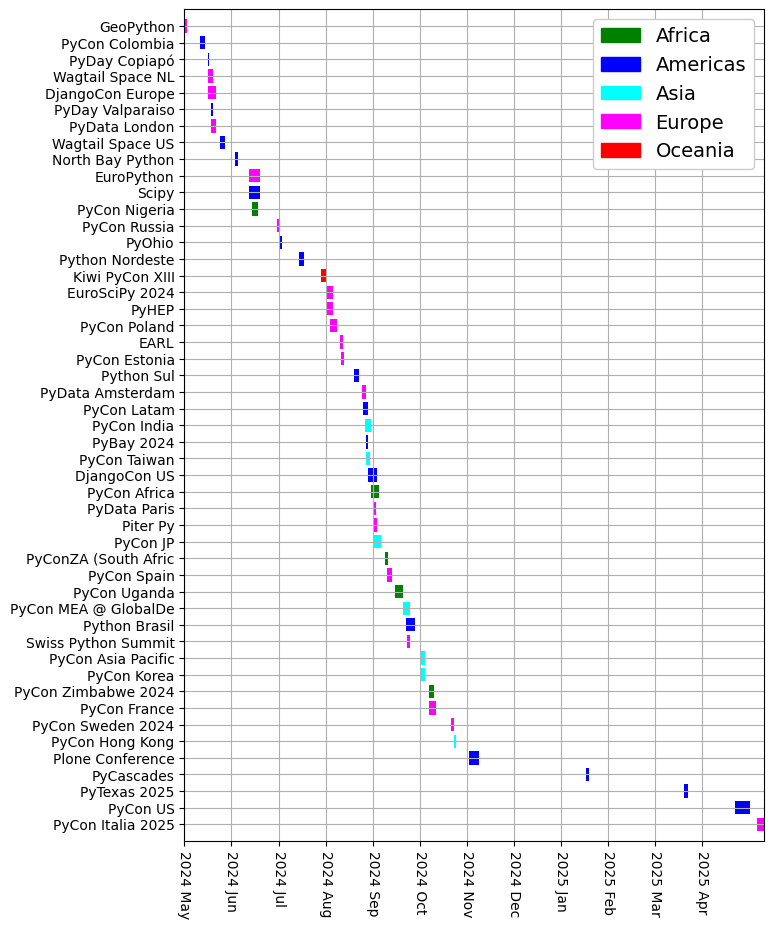

In [146]:
import matplotlib.pyplot as plt

maximum_subject_length = 20
event_count = len(gantt_table)
figure_width = 2 + maximum_offset * 0.015
figure_height = 1 + event_count * 0.2
plt.figure(figsize=(figure_width, figure_height))  
for i, r in gantt_table.iterrows():
    try:
        c = color_names[region_names.index(r['Region'])]
    except ValueError:
        c = 'black'
    plt.barh(
        y=r['Subject'][:maximum_subject_length],
        width=r['Length'], left=r['Offset'], color=c)
plt.xlim(0, last_event['Offset'] + last_event['Length'])
plt.ylim(-1, event_count)
plt.gca().invert_yaxis()
plt.grid()
plt.legend(handles=patches, labels=region_names, fontsize=14, framealpha=1)
plt.xticks(xtick_locations, xtick_labels, rotation=270)
plt.savefig(output_folder / 'gantt.svg', bbox_inches='tight')